Theoretical classifier error probability: 0.1058


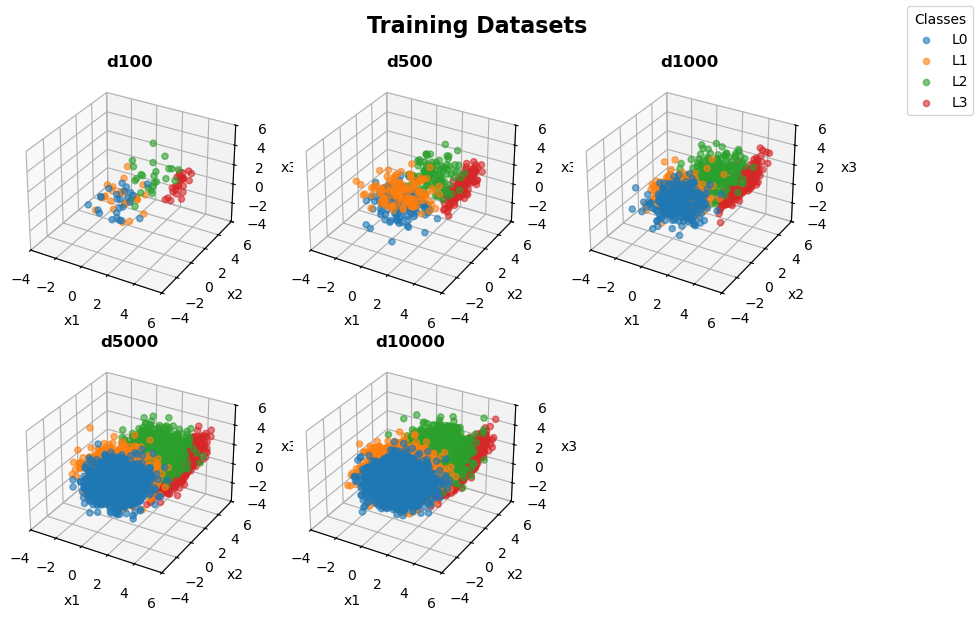

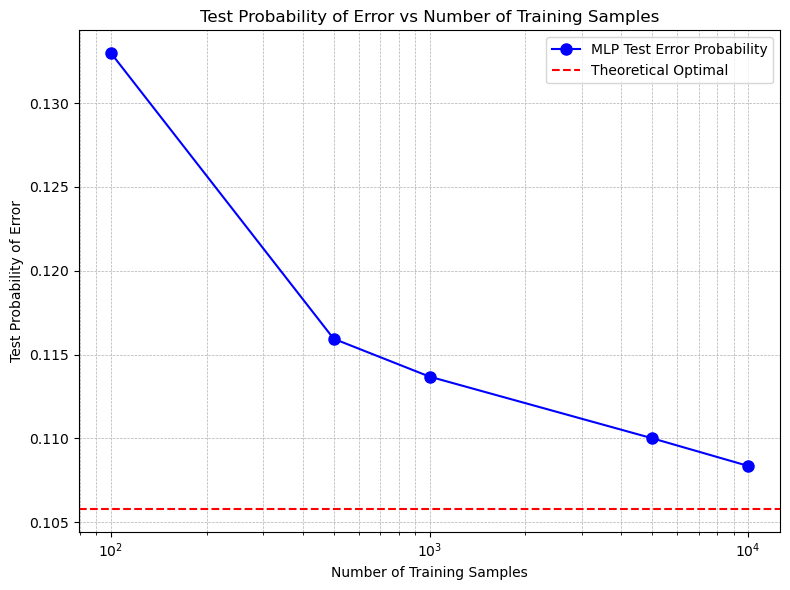

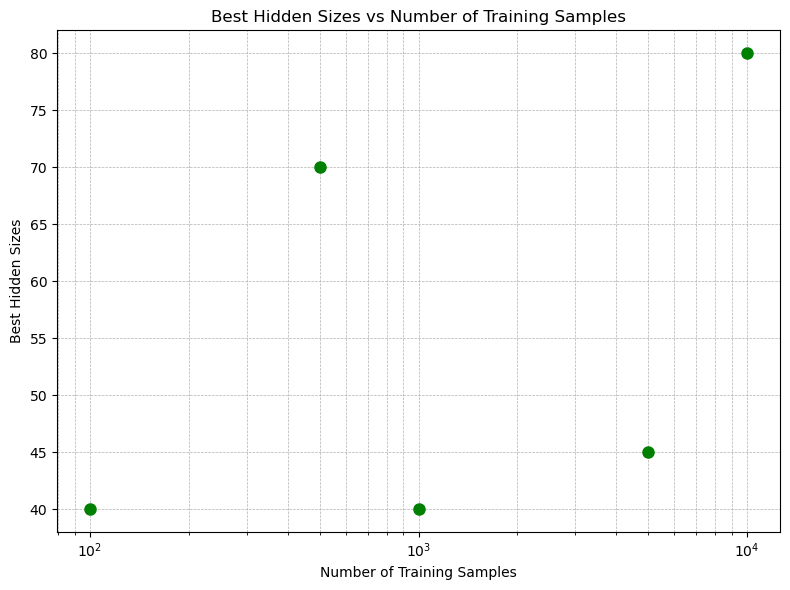

In [24]:
## Define the data distribution
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Parameters
num_classes = 4
dim = 3  # 3D feature space


# Parameters for four classes (fixed mean vectors and covariance matrices)
means = [
    np.array([0.5, 0.0, 0.0]),
    np.array([0.0, 1.0, 0.0]),
    np.array([2.0, 2.0, 2.0]),
    np.array([3.0, 4.0, 0.0])
]

# Covariance matrices with moderate diagonal elements and small off-diagonals for overlap
covariances = [
    np.array([[1.0, 0.2, 0.1], [0.2, 0.2, 0.2], [0.1, 0.2, 1.0]]),
    np.array([[1.2, 0.1, 0.2], [0.1, 0.3, 0.1], [0.2, 0.1, 1.2]]),
    np.array([[0.8, 0.3, 0.1], [0.3, 0.3, 0.3], [0.1, 0.3, 1.1]]),
    np.array([[0.2, 0.1, 0.3], [0.1, 0.9, 0.2], [0.3, 0.2, 1.0]])
]

# Uniform class priors
priors = [0.25, 0.25, 0.25, 0.25]

# Generate train/test data based on the specified distribution
def generate_data(n_samples):
    X, y = [], []
    for i in range(len(means)):
        samples = multivariate_normal.rvs(mean=means[i], cov=covariances[i], size=int(n_samples * priors[i]))
        labels = np.full(samples.shape[0], i)
        X.append(samples)
        y.append(labels)
    return np.vstack(X), np.hstack(y)

# Generate a test dataset of 100,000 samples
X_test, y_test = generate_data(100000)


def theoretical_map_classifier(X_test):
    predictions = []
    for x in X_test:
        # Calculate posterior probabilities for each class
        posteriors = []
        for i in range(len(means)):
            likelihood = multivariate_normal.pdf(x, mean=means[i], cov=covariances[i])
            posterior = likelihood * priors[i]  # P(x|C_i) * P(C_i)
            posteriors.append(posterior)
        
        # # Normalize to get proper posterior probabilities
        posteriors = np.array(posteriors)
        posteriors /= posteriors.sum()  # Normalize to sum to 1
        
        # Classify as the class with the highest posterior probability
        predictions.append(np.argmax(posteriors))
    return np.array(predictions)

# Evaluate the theoretical classifier on the test set
def evaluate_theoretical_classifier(X_test, y_test):
    predictions = theoretical_map_classifier(X_test)
    error_count = np.sum(predictions != y_test)
    error_prob = error_count / len(y_test)
    return error_prob

# Evaluate the theoretically optimal classifier
optimal_error_prob = evaluate_theoretical_classifier(X_test, y_test)
print(f"Theoretical classifier error probability: {optimal_error_prob:.4f}")

# Define a two-layer MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_func):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.activation = activation_func
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.hidden(x))
        return self.softmax(self.output(x))

# Set activation function
activation_func = nn.ELU()  # Changeable activation function

# Cross-validation to select the optimal number of hidden units
def cross_validate(train_data, train_labels, hidden_sizes, k=10):
    best_hidden_size = None
    best_accuracy = 0

    for hidden_dim in hidden_sizes:
        kf = KFold(n_splits=k)
        accuracies = []
        
        for train_index, val_index in kf.split(train_data):
            X_train, X_val = train_data[train_index], train_data[val_index]
            y_train, y_val = train_labels[train_index], train_labels[val_index]

            model = MLP(input_dim=3, hidden_dim=hidden_dim, output_dim=len(priors), activation_func=activation_func)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.01)
            
            for epoch in range(150):  # Limited epochs for cross-validation
                optimizer.zero_grad()
                outputs = model(torch.tensor(X_train, dtype=torch.float32))
                loss = criterion(outputs, torch.tensor(y_train, dtype=torch.long))
                loss.backward()
                optimizer.step()
                
            with torch.no_grad():
                val_outputs = model(torch.tensor(X_val, dtype=torch.float32))
                _, predicted = torch.max(val_outputs, 1)
                accuracies.append(accuracy_score(y_val, predicted.numpy()))
        
        avg_accuracy = np.mean(accuracies)
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_hidden_size = hidden_dim

    return best_hidden_size

# Training and evaluation of MLP models for different training dataset sizes
train_sizes = [100, 500, 1000, 5000, 10000]
hidden_sizes = [5, 8, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80]  # Expanded hidden layer sizes
error_probabilities = []
best_hidden_sizes = []
figSamples = plt.figure(figsize=(10, 6))

for i, n_samples in enumerate(train_sizes):
    X, y = generate_data(n_samples)
    
    ax = figSamples.add_subplot(2, 3, i + 1, projection='3d')  # 2 rows and 3 columns layout
    for class_id in range(num_classes):
        class_data = X[y == class_id]
        ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'L{class_id}', s=20, alpha=0.6)
    
    ax.set_title(f'd{n_samples}', fontsize=12, fontweight='bold')
    ax.set_xlabel('x1', fontsize=10)
    ax.set_ylabel('x2', fontsize=10)
    ax.set_zlabel('x3', fontsize=10)
    ax.set_xlim(-4, 6)
    ax.set_ylim(-4, 6)
    ax.set_zlim(-4, 6)
    ax.grid(True, linestyle='--', linewidth=0.5)
    
    # Find the optimal hidden layer size through cross-validation
    best_hidden_size = cross_validate(X, y, hidden_sizes)
    best_hidden_sizes.append(best_hidden_size)
    
    # Train the final MLP model with the optimal hidden size
    model = MLP(input_dim=3, hidden_dim=best_hidden_size, output_dim=len(priors), activation_func=activation_func)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(150):  # Full training with more epochs
        optimizer.zero_grad()
        outputs = model(torch.tensor(X, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(y, dtype=torch.long))
        loss.backward()
        optimizer.step()

    # Evaluate the trained MLP model on the test set
    with torch.no_grad():
        test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
        _, predicted = torch.max(test_outputs, 1)
        accuracy = accuracy_score(y_test, predicted.numpy())
        error_probabilities.append(1 - accuracy)

# Add a legend and show the plot
# Add a single legend outside the subplots
handles, labels = ax.get_legend_handles_labels()
figSamples.legend(handles[:num_classes], labels[:num_classes], loc='upper right', title="Classes")
plt.suptitle("Training Datasets", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.88, right=0.85, hspace=0.2)  # Reduced hspace for tighter rows
plt.show()

# Plot 1: Test Error Probability with Theoretical Optimal
plt.figure(figsize=(8, 6))
plt.semilogx(train_sizes, error_probabilities, marker='o', markersize=8, label='MLP Test Error Probability', color='blue')
plt.axhline(y=optimal_error_prob, color='red', linestyle='--', label='Theoretical Optimal')
plt.xlabel('Number of Training Samples')
plt.ylabel('Test Probability of Error')
plt.title('Test Probability of Error vs Number of Training Samples')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Plot 2: Best Hidden Sizes for Each Training Size
plt.figure(figsize=(8, 6))
plt.semilogx(train_sizes, best_hidden_sizes, linestyle='', marker='o', markersize=8, color='green')  # Only markers
plt.xlabel('Number of Training Samples')
plt.ylabel('Best Hidden Sizes')
plt.title('Best Hidden Sizes vs Number of Training Samples')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
